# Stratified LD Score Regression 
This notebook implements the pipepline of [S-LDSC](https://github.com/bulik/ldsc/wiki) for LD score and functional enrichment analysis. It is written by Anmol Singh (singh.anmol@columbia.edu), with input from Dr. Gao Wang.

**FIXME: the initial draft is complete but pending Gao's review and documentation with minimal working example**

The pipeline is developed to integrate GWAS summary statistics data, annotation data, and LD reference panel data to compute functional enrichment for each of the epigenomic annotations that the user provides using the S-LDSC model. We will first start off with an introduction, instructions to set up, and the minimal working examples. Then the workflow code that can be run using SoS on any data will be at the end. 

## A brief review on Stratified LD score regression

Here I briefly review LD Score Regression and what it is used for. For more in depth information on LD Score Regression please read the following three papers:

1. "LD Score regression distinguishes confounding from polygenicity in genome-wide association studies" by Sullivan et al (2015)

2. "Partitioning heritability by functional annotation using genome-wide association summary statistics" by Finucane et al (2015)

3. "Linkage disequilibrium–dependent architecture of human complex traits shows action of negative selection" by Gazal et al (2017)

As stated in Sullivan et al 2015, confounding factors and polygenic effects can cause inflated test statistics and other methods cannot distinguish between inflation from confounding bias and a true signal. LD Score Regression (LDSC) is a technique that aims to identify the impact of confounding factors and polygenic effects using information from GWAS summary statistics. 

This approach involves using regression to mesaure the relationship between Linkage Disequilibrium (LD) scores and test statistics of SNPs from the GWAS summary statistics. Variants in LD with a "causal" variant show an elevation in test statistics in association analysis proportional to their LD (measured by $r^2$) with the causal variant within a certain window size (could be 1 cM, 1kB, etc.). In contrast, inflation from confounders such as population stratification that occur purely from genetic drift will not correlate with LD. For a polygenic trait, SNPs with a high LD score will have more significant χ2 statistics on average than SNPs with a low LD score. Thus, if we regress the $\chi^2$ statistics from GWAS against LD Score, the intercept minus one is an estimator of the mean contribution of confounding bias to the inflation in the test statistics. The regression model is known as LD Score regression. 

### LDSC model

Under a polygenic assumption, in which effect sizes for variants are drawn independently from distributions with variance proportional to  $1/(p(1-p))$ where p is the minor allele frequency (MAF), the expected $\chi^2$ statistic of variant j is:

$$E[\chi^2|l_j] = Nh^2l_j/M + Na + 1 \quad (1)$$

where $N$ is the sample size; $M$ is the number of SNPs, such that $h^2/M$ is the average heritability explained per SNP; $a$ measures the contribution of confounding biases, such as cryptic relatedness and population stratification; and $l_j = \sum_k r^2_{jk}$ is the LD Score of variant $j$, which measures the amount of genetic variation tagged by $j$. A full derivation of this equation is provided in the Supplementary Note of Sullivan et al (2015). An alternative derivation is provided in Supplementary Note of Zhu and Stephens (2017) AoAS.

From this we can see that LD Score regression can be used to compute SNP-based heritability for a phenotype or trait, from GWAS summary statistics and does not require genotype information like other methods such as REML do. 

### Stratified LDSC

Heritability is the proportion of phenotypic variation (VP) that is due to variation in genetic values (VG) and thus can tell us how much of the difference in observed phenotypes in a sample is due to difference in genetics in the sample. It can also be extended to analyze partitioned heritability for a phenotype/trait split over categories. 

For Partitioned Heritability or Stratified LD Score Regression (S-LDSC) more power is added to our analysis by leveraging LD Score information as well as using SNPs that haven't reached Genome Wide Significance to partition heritability for a trait over categories which many other methods do not do. 


S-LDSC relies on the fact that the $\chi^2$ association statistic for a given SNP includes the effects of all SNPs tagged by this SNP meaning that in a region of high LD in the genome the given SNP from the GWAS represents the effects of a group of SNPs in that region.

S-LDSC determines that a category of SNPs is enriched for heritability if SNPs with high LD to that category have more significant $\chi^2$ statistics than SNPs with low LD to that category.

Here, enrichment of a category is defined as the proportion of SNP heritability in the category divided by the proportion of SNPs in that category.

More precisely, under a polygenic model, the expected $\chi^2$ statistic of SNP $j$ is

$$E[\chi^2_j] = N\sum_CT_Cl(j,C) + Na + 1 \quad (2)$$

where $N$ is sample size, C indexes categories, $ℓ(j, C)$ is the LD score of SNP j with respect to category $l(j,C) = \sum_{k\epsilon C} r^2_{jk}$, $a$ is a term that measures the contribution of confounding biases, and if the categories are disjoint, $\tau_C$ is the per-SNP heritability in category $C$; if the categories overlap, then the per-SNP heritability of SNP j is $\sum_{C:j\epsilon C} \tau_C$.  Equation 2 allows us to estimate $\tau_C$ via a (computationally simple) multiple regression of $\chi^2$ against $ℓ(j, C)$, for either a quantitative or case-control study. 

To see how these methods have been applied to real world data as well as a further discussion on methods and comparisons to other methods please read the three papers listed at the top of the document.

## Command Interface

In [1]:
!sos run LDSC_Code.ipynb -h

usage: sos run LDSC_Code.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  make_annot
  munge_sumstats_no_sign
  munge_sumstats_sign
  calc_ld_score
  convert_ld_snps
  calc_enrichment

Sections
  make_annot:
    Workflow Options:
      --bed VAL (as str, required)
                        path to bed file
      --bim VAL (as str, required)
                        path to bim file
      --annot VAL (as str, required)
                        name of output annotation file
  munge_sumstats_no_sign:
    Workflow Options:
      --sumst VAL (as str, required)
                        path to summary statistic file
      --alleles 'w_hm3.snplist'
                        path to Hapmap3 SN

## Example Analysis 1: Setting up Summary Statistic File

This section will go over how to set up the summary statistic file for the phenotype you are trying to analyze. The summary statistic file we will use is for BMI and it can be downloaded here: http://www.broadinstitute.org/collaboration/giant/index.php/GIANT_consortium_data_files. For the tutorial you also need the list of hapmap snps to restrict the summary statistic file to the recommended HapMap Phase 3 SNPs that will be used in the regression. The authors recommend restricting the analysis to HapMap Phase 3 SNPs because most GWAS summary statistics do not have information about imputation quality, thus using HapMap SNPs insures that you are using well-imputed and common variants for the analysis. This file can be downloaded here: https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/w_hm3.snplist.bz2. The summary statistic file should have the following columns with the following names for the analysis to work:

SNP -- SNP identifier (e.g., rs number)

N -- sample size (which may vary from SNP to SNP).

P -- p-value.

A1 -- first allele (effect allele)

A2-- second allele (other allele)

Signed Summary Statistic (Can be Z, BETA, or Odds Ratio(label as OR)), is optional if A1 is the risk increasing allele as you can use the other munge_sumstats option in the workflow.

For the tutorial, the BMI summary statistic file is not signed so we will use the not_signed option in the workflow. Once you have set up the summary statistic file with these column headers you can reformat it for the analysis using the following command in the SoS workflow:

In [ ]:
sos run LDSC_Code.ipynb munge_sumstats_no_sign --sumstats GIANT_BMI_Speliotes2010_publicrelease_HapMapCeuFreq.txt\
--output-sumst-2 BMI\
--alleles w_hm3.snplist\
--signed False

Explanation of flags:
    
    1. `--sumstats`: path to summary statistic file
    
    2. `--output-sumst-2`: Prefix for output file name
    
    3. `--alleles`: path to hm3 alleles for merging
    
    4. `--signed`: is the summary statistic file signed or not, logical flag (True or False)
    
This will return a file called BMI.sumstats.gz which is a gzipped file that will be used as the summary statistic file in our analysis. It contains a row for each variant as well as the Allele Information and the Z score calculated by the workflow.

## Example Analysis 2: Partitioned LD Score Regression
We first make the annotation file with respect to a specific annotation bed file using the make_annot option in the workflow. For the purposes of this tutorial we will use a Histone Mark annotation from Adipose Tissue, Adipose_Tissue.H3K27ac. I have provided the bed file for this annotation on a google drive folder (https://drive.google.com/drive/folders/1HdG-QsCl6fAspSxGsuoOCapwfnXCyfnU?usp=sharing) so you can download it to run the commands below. **Please place the plink files into a folder called plink files and make the output annotation directory annot_files before running the command below. When running on your own data in the future, please encode the annotation file names with feat_#_chr_# as the prefix so that the future commands in the pipeline will work. The command to make the annotation file for this annotation for one chromosome of the 1000 Genome Phase 3 variants (the reference data) for the tutorial is listed here:**

In [ ]:
sos run LDSC_code.ipynb make_annot \
		--bed Adipose_Tissue.H3K27ac.bed \
		--bim plink_files/1000G.EUR.QC.22.bim \
		--annot annot_files/feat_1_chr_22.annot.gz

Explanation of flags:
    
    1. `--bim`: path to 1000 Genome bim file
    
    2. `--bed`: Path to bed file for annotation
    
    3. `--annot`: output file name
    
This command will output a file with 0/1 for each variant in the bim file which corresponds to whether this specific variant is within the regions described in the annotation file.

## Example Analysis 3: Calculate LD Scores

After the annotation file is made we can use it to calculate the LD Scores for this annotation. In this case the program recommends that you only print LD Scores for HapMap Phase 3 SNPs. This can be achieved by using the hapmap snplist file which can be found here: https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/w_hm3.snplist.bz2. You must get rid of the A1 and A2 columns in this file and keep only the SNP column before using the command below

Make sure your annotation files have the same prefix as your LD Score files that you will create as the workflow will not be able to read the annotation files if they have a different prefix when you try to conduct the regression.

The code below shows how to use the workflow to calculate LD Scores for the tutorial annotation. The workflow will automatically calculate LD Scores for each chromosome and the base or reference annotation using one simple command:

In [ ]:
sos run LDSC_code.ipynb calc_ld_score \
		--bim plink_files \
		--annot_files annot_files \
		--num_features 1

Explanation of flags:
    
    1. `--bim`: path to bim files directory
    
    2. `--num_features`: Number of Epigenomic Features in analysis
    
    3. `--annot`: path to annotation files directory
    
    
This command outputs the same gzipped LD score file as the simple case but instead of just an LD Score column, it will have one LD Score column for each annotation that you are calculating LD Scores for.

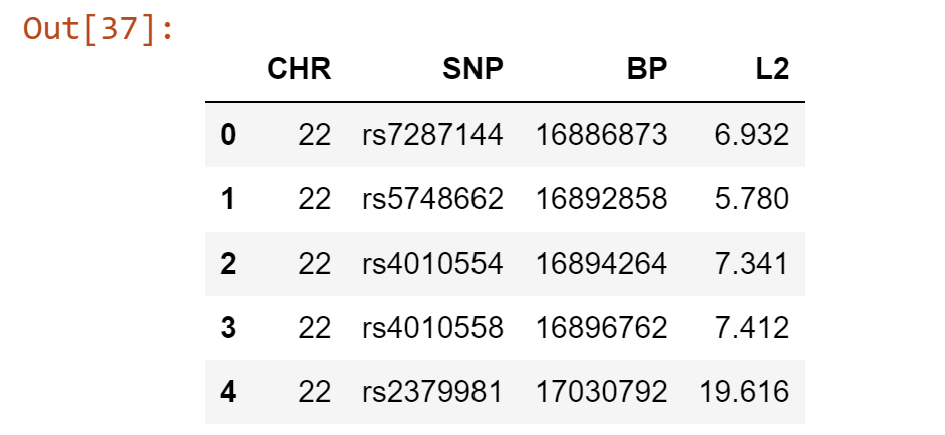

Now that we have calculated the LD Scores for each chromosome for our annotation, we can use these LD Scores to conduct the Partitioned LD Score Regression for our annotation. In this case we have to make sure that our annotation files are in the same folder and have the same prefix name as our LD Score files. Now we can conduct the Regression for our annotation:

In [ ]:
sos run LDSC_code.ipynb calc_enrichment --sumstats BMI.sumstats.gz\
    --ref_ld annot_files/base.,annot_files/feat_1_chr_\ 
    --w_ld weights_hm3_no_hla/weights.\
    --overlap-annot\
    --frq_file 1000G_frq/1000G.mac5eur.\
    --pheno BMI\
    --num_features 1

Here the comma indicates that we are concatinating the baseline model with the new annotation.

The results our outputted in a .results file which shows the proportion of heritability and enrichment attributable to each category for the trait you are studying, in this case BMI.

The results file for this analysis looks like this, where L2_1 represents our Adipose Tissue Annotation and baseL2_0 describes the baseline annotation:

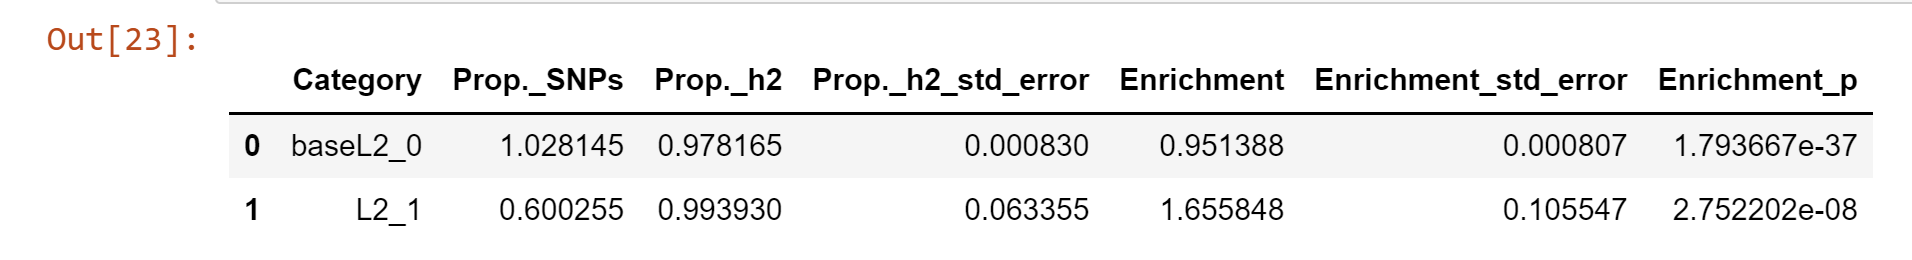


Explanation of flags:
    
    
    1. `sumstats`: #Path to Summary statistics File

    2. `ref_ld`: Path to Reference LD Scores File Directory 
    
    3. `w_ld`: Path to LD Weight Files
    
    4. `frq_file`: Path to Frequency Files
    
    5. `pheno`: Phenotype of Summary statistic file, for output prefix
    
    6. `num_features`: Number of Features in Analysis 
    